## Count violations of rebalancing service standard

This notebook estimates the number of violations of rebalancing standards and the total fine.

Rebalancing standards are:

|     Service Metric                  |     Description                                                                                                                                                                                                                   |     Penalty                                          |
|-------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------|
|     Rebalancing – Peak Hours        |     Stations   must not be completely full or completely empty between 8am and 8pm Monday   through Friday. No penalties sought unless the next closest station in any   direction is also full or empty at the same time.        |     $50   per hour per station, after 60 minutes     |
|     Rebalancing – Off-peak Hours    |     Stations   must not be completely full or completely empty between 8:01pm and 7:59am any   day of the week. No penalties sought unless the next closest station in any   direction is also full or empty at the same time.    |     $50   per hour per station, after 120 minutes    |

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from libpysal.weights import KNN, DistanceBand

In [2]:
dataset = pd.read_parquet('../dataset.parquet')

In [3]:
stations_geo = (
    gpd.read_file('../stations_geo.geojson')
    .set_index('station_id')
    .to_crs(2263)
)

In [4]:
dataset.head()

capacity   
last_updated              station_id                                       
2024-03-12 17:40:49-04:00 66dc2995-0aca-11e7-82f6-3863bb44ef7c        51  \
                          06439006-11b6-44f0-8545-c9d39035f32a        48   
                          19d17911-1e4a-41fa-b62b-719aa0a6182e        39   
                          1861678548643203686                         25   
                          cd2d9dab-7708-4685-a56f-9412c738de7e        23   

                                                                is_renting   
last_updated              station_id                                         
2024-03-12 17:40:49-04:00 66dc2995-0aca-11e7-82f6-3863bb44ef7c           0  \
                          06439006-11b6-44f0-8545-c9d39035f32a           0   
                          19d17911-1e4a-41fa-b62b-719aa0a6182e           0   
                          1861678548643203686                            1   
                          cd2d9dab-7708-4685-a56f-9412c738de7e           1   

                                                                is_returning   
last_updated              station_id                                           
2024-03-12 17:40:49-04:00 66dc2995-0aca-11e7-82f6-3863bb44ef7c             0  \
                          06439006-11b6-44f0-8545-c9d39035f32a             0   
                          19d17911-1e4a-41fa-b62b-719aa0a6182e             0   
                          1861678548643203686                              1   
                          cd2d9dab-7708-4685-a56f-9412c738de7e             1   

                                                                num_docks_available   
last_updated              station_id                                                  
2024-03-12 17:40:49-04:00 66dc2995-0aca-11e7-82f6-3863bb44ef7c                    0  \
                          06439006-11b6-44f0-8545-c9d39035f32a                    0   
                          19d17911-1e4a-41fa-b62b-719aa0a6182e                    0   
                          1861678548643203686                                     8   
                          cd2d9dab-7708-4685-a56f-9412c738de7e                    1   

                                                                num_bikes_available   
last_updated              station_id                                                  
2024-03-12 17:40:49-04:00 66dc2995-0aca-11e7-82f6-3863bb44ef7c                    0  \
                          06439006-11b6-44f0-8545-c9d39035f32a                    0   
                          19d17911-1e4a-41fa-b62b-719aa0a6182e                    0   
                          1861678548643203686                                    15   
                          cd2d9dab-7708-4685-a56f-9412c738de7e                   22   

                                                                num_ebikes_available   
last_updated              station_id                                                   
2024-03-12 17:40:49-04:00 66dc2995-0aca-11e7-82f6-3863bb44ef7c                     0  \
                          06439006-11b6-44f0-8545-c9d39035f32a                     0   
                          19d17911-1e4a-41fa-b62b-719aa0a6182e                     0   
                          1861678548643203686                                      8   
                          cd2d9dab-7708-4685-a56f-9412c738de7e                     1   

                                                                num_bikes_disabled   
last_updated              station_id                                                 
2024-03-12 17:40:49-04:00 66dc2995-0aca-11e7-82f6-3863bb44ef7c                   0  \
                          06439006-11b6-44f0-8545-c9d39035f32a                   0   
                          19d17911-1e4a-41fa-b62b-719aa0a6182e                   0   
                          1861678548643203686                                    2   
                          cd2d9dab-7708-4685-a56f-9412c738de7e        

find zero bike or zero dock durations that exceed off-peak standard.

remove outside-NYC and isolated stations

In [5]:
dist_w = DistanceBand.from_dataframe(
    stations_geo,
    threshold=2000,
    binary=True
)

c:\Users\dlevine\Anaconda3\envs\citibike-analysis\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 4 islands with ids: 655ad2f2-6bcc-4eee-95a9-4f528c0b81cd, 324af152-33ea-48a7-8bb0-ad8b6f31571f, 66dd5e69-0aca-11e7-82f6-3863bb44ef7c, 66dd5f24-0aca-11e7-82f6-3863bb44ef7c.
  warnings.warn(message)


In [6]:
(
    stations_geo
    .assign(
        component = dist_w.component_labels
    )
    .explore(
        column='component',
        cmap='tab20',
        tiles='CartoDB Positron',
        tooltip='component'
    )
)

drop stations other than the main network, including all outside NYC

In [7]:
stations_geo = (
    stations_geo
    .loc[
        dist_w.component_labels==0
    ]
)

find nearest neighbor

In [8]:
nearest_w = KNN.from_dataframe(
    stations_geo,
    k=1,
    distance_metric='euclidean'
)

c:\Users\dlevine\Anaconda3\envs\citibike-analysis\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 649 disconnected components.
  warnings.warn(message)


peek at result

(974310.2038590678, 1029211.9356384312, 165428.1167800154, 266804.9686295608)

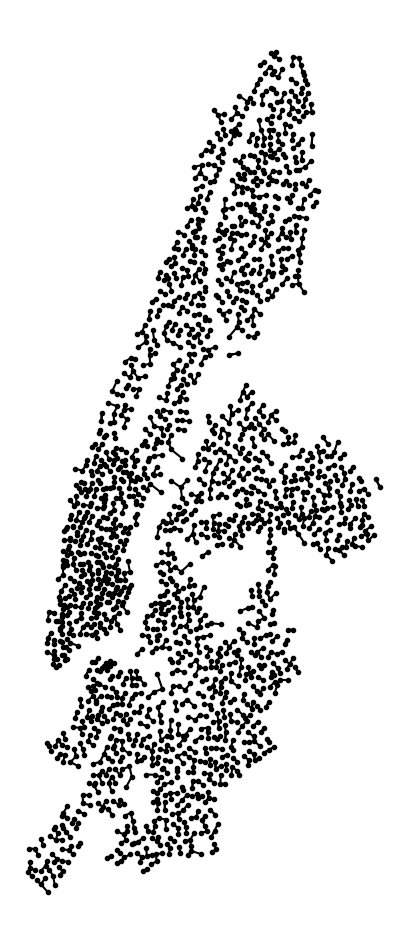

In [9]:
fig,ax = plt.subplots(figsize=(5,12))

nearest_w.plot(
    gdf=stations_geo, 
    ax=ax,
    node_kws=dict(marker='.')
)

plt.axis('off')

In [10]:
nearest_station_mapper = {station_id:nearest_w.neighbors[station_id][0] for station_id in stations_geo.index}

## subset peak and off-peak times
run through each station and find durations when that and nearest have zero bikes or zero docks

In [11]:
dataset = (
    dataset
    .reset_index()
    .assign(
        hour = lambda row: row['last_updated'].dt.hour,
        day_of_week = lambda row: row['last_updated'].dt.dayofweek
    )
    .set_index(['station_id','last_updated'])
    .sort_index()
)

### peak

In [12]:
peak_times = (
    dataset
    [
        (dataset['day_of_week'] < 5) &
        (
            (dataset['hour'] >= 8) &
            (dataset['hour'] < 20)
        )
    ]
)

loop through stations and find start, time, end time, and durations of intances when station and nearest have zero bikes or zero docks

In [13]:
zero_peak_dock_durations = []
zero_peak_bike_durations = []

for station_id in tqdm(stations_geo.index.unique()):

    nearest_station_id = nearest_station_mapper.get(station_id)

    station_subset = (
        (
            peak_times
            .loc[[
                station_id,
                nearest_station_id
                ],:
            ]
            .groupby('last_updated')
            .agg({
                'num_bikes_available':sum,
                'num_docks_available':sum,
                'is_renting':'first',
                'is_returning':'first'
            })
            .reset_index()
            .assign(
                previous_time = lambda row: row.shift(1)['last_updated'],
                previous_docks = lambda row: row.shift(1)['num_docks_available'],
                previous_bikes = lambda row: row.shift(1)['num_bikes_available']
            )
        )
    )

    zero_dock_start = None
    zero_bike_start = None
    restarted_counter = False
    

    for i,row in station_subset.iloc[1:].iterrows():
        
        
        # start counter when this row is zero and the counter is not yet running
        
        if (
            (row['num_docks_available'] == 0) and 
            (row['is_returning'] == 1) and
            (zero_dock_start is None)
        ): 
            zero_dock_start = row['last_updated']
            restarted_counter = True

        if (
            (row['num_bikes_available'] == 0) and
            (row['is_renting'] == 1) and
            (zero_bike_start is None)
        ): 
            zero_bike_start = row['last_updated']
            restarted_counter = True
            
        if restarted_counter:
            restarted_counter = False
            continue

        # if there is a gap of more than 40 minutes, end the counter at the previous time

        if (
            (row['last_updated'] - row['previous_time']) > pd.Timedelta('40min')
        ):
            
            if zero_dock_start is not None:
                zero_dock_end = row['previous_time']
                zero_peak_dock_durations.append((station_id,zero_dock_start,zero_dock_end,(zero_dock_end - zero_dock_start)))
                zero_dock_start = None
                zero_dock_end = None

            if zero_bike_start is not None:
                zero_bike_end = row['previous_time']
                zero_peak_bike_durations.append((station_id,zero_bike_start,zero_bike_end,(zero_bike_end - zero_bike_start)))
                zero_bike_start = None
                zero_bike_end = None

            continue

        # end counter when this row is not zero

        assert ((row['last_updated'] - row['previous_time']) <= pd.Timedelta('40min'))

        if (
            (zero_dock_start is not None) and 
            (row['num_docks_available'] != 0)
        ): 
            zero_dock_end = row['last_updated']
            zero_peak_dock_durations.append((station_id,zero_dock_start,zero_dock_end,(zero_dock_end - zero_dock_start)))
            zero_dock_start = None
            zero_dock_end = None

        if (
            (zero_bike_start is not None) and 
            (row['num_bikes_available'] != 0)
        ): 
            zero_bike_end = row['last_updated']
            zero_peak_bike_durations.append((station_id,zero_bike_start,zero_bike_end,(zero_bike_end - zero_bike_start)))
            zero_bike_start = None
            zero_bike_end = None
        

100%|██████████| 2125/2125 [01:27<00:00, 24.32it/s]


In [14]:
zero_peak_dock_durations_data= pd.DataFrame.from_records(
    zero_peak_dock_durations, 
    columns=['station_id','zero_dock_start','zero_dock_end', 'zero_dock_duration']
)

zero_peak_bike_durations_data= pd.DataFrame.from_records(
    zero_peak_bike_durations, 
    columns=['station_id','zero_bike_start','zero_bike_end', 'zero_bike_duration']
)


In [15]:
(
    zero_peak_dock_durations_data
    [
        zero_peak_dock_durations_data['zero_dock_duration'].ge(pd.Timedelta('1hours'))
    ]
)

,station_id,zero_dock_start,zero_dock_end,zero_dock_duration
1,cd2d9dab-7708-4685-a56f-9412c738de7e,2024-03-14 08:44:25-04:00,2024-03-14 10:26:26-04:00,0 days 01:42:01
3,cd2d9dab-7708-4685-a56f-9412c738de7e,2024-03-15 08:43:19-04:00,2024-03-15 10:08:19-04:00,0 days 01:25:00
4,cd2d9dab-7708-4685-a56f-9412c738de7e,2024-03-15 10:25:19-04:00,2024-03-15 11:34:18-04:00,0 days 01:08:59
5,cd2d9dab-7708-4685-a56f-9412c738de7e,2024-03-15 14:11:03-04:00,2024-03-15 15:19:06-04:00,0 days 01:08:03
6,cd2d9dab-7708-4685-a56f-9412c738de7e,2024-03-18 08:14:08-04:00,2024-03-18 10:08:08-04:00,0 days 01:54:00
...,...,...,...,...
4180,0efa08a3-1c38-48fe-ab37-8c9b72b20126,2024-03-20 16:23:38-04:00,2024-03-20 17:47:39-04:00,0 days 01:24:01
4200,e72f0aec-2293-4636-988c-b9d30df092f8,2024-03-18 10:47:08-04:00,2024-03-18 11:47:56-04:00,0 days 01:00:48
4202,e72f0aec-2293-4636-988c-b9d30df092f8,2024-03-19 10:07:58-04:00,2024-03-19 11:08:52-04:00,0 days 01:00:54
4204,e72f0aec-2293-4636-988c-b9d30df092f8,2024-03-19 12:48:51-04:00,2024-03-19 14:10:10-04:00,0 days 01:21:19


In [16]:
zero_peak_durations = pd.concat([
    (
        zero_peak_dock_durations_data
        [['station_id','zero_dock_duration']]
        .rename(columns={'zero_dock_duration':'zero_duration'})
        .assign(duration_type = 'dock')
    ),
    (
        zero_peak_bike_durations_data
        [['station_id','zero_bike_duration']]
        .rename(columns={'zero_bike_duration':'zero_duration'})
        .assign(duration_type = 'bike')
    )
])

In [17]:
(
    zero_peak_durations
    [
        zero_peak_durations['zero_duration'].ge(pd.Timedelta('1hours'))
    ]
).shape[0]

1188

In [18]:
(
    zero_peak_durations
    [
        zero_peak_durations['zero_duration'].ge(pd.Timedelta('1hours'))
    ]
    .assign(
        time_over = lambda row: row['zero_duration'] - pd.Timedelta('1hours'),
        hours_over = lambda row: (row['zero_duration'] - pd.Timedelta('1hours')) / pd.Timedelta('1hour'),
        whole_hours_over = lambda row: np.floor((row['zero_duration'] - pd.Timedelta('1hours')) / pd.Timedelta('1hour')),
        fine = lambda row: row['whole_hours_over'] * 50
    )
)

,station_id,zero_duration,duration_type,time_over,hours_over,whole_hours_over,fine
1,cd2d9dab-7708-4685-a56f-9412c738de7e,0 days 01:42:01,dock,0 days 00:42:01,0.700278,0.0,0.0
3,cd2d9dab-7708-4685-a56f-9412c738de7e,0 days 01:25:00,dock,0 days 00:25:00,0.416667,0.0,0.0
4,cd2d9dab-7708-4685-a56f-9412c738de7e,0 days 01:08:59,dock,0 days 00:08:59,0.149722,0.0,0.0
5,cd2d9dab-7708-4685-a56f-9412c738de7e,0 days 01:08:03,dock,0 days 00:08:03,0.134167,0.0,0.0
6,cd2d9dab-7708-4685-a56f-9412c738de7e,0 days 01:54:00,dock,0 days 00:54:00,0.900000,0.0,0.0
...,...,...,...,...,...,...,...
1858,1abd4668-ed6b-4930-8177-17239ae75a9e,0 days 01:01:00,bike,0 days 00:01:00,0.016667,0.0,0.0
1859,814dd1a9-100c-4b1b-8110-6319bbd464e9,0 days 03:41:59,bike,0 days 02:41:59,2.699722,2.0,100.0
1868,081d243e-d75e-4e2a-bdae-a990b2397532,0 days 01:07:59,bike,0 days 00:07:59,0.133056,0.0,0.0
1871,1913988158376585970,0 days 05:20:55,bike,0 days 04:20:55,4.348611,4.0,200.0


In [19]:
total_peak_fine = (
    zero_peak_durations
    [
        zero_peak_durations['zero_duration'].ge(pd.Timedelta('1hours'))
    ]
    .assign(
        whole_hours_over = lambda row: np.floor((row['zero_duration'] - pd.Timedelta('1hours')) / pd.Timedelta('1hour')),
        fine = lambda row: row['whole_hours_over'] * 50
    )
    ['fine']
    .sum()
)

print(f"$ {total_peak_fine:,.0f}")

$ 53,450


### and offpeak:

In [20]:
offpeak_times = (
    dataset
    [
        (dataset['hour'] < 8) |
        (dataset['hour'] >= 20)
    ]
)

In [21]:
zero_offpeak_dock_durations = []
zero_offpeak_bike_durations = []

for station_id in tqdm(stations_geo.index):

    nearest_station_id = nearest_station_mapper.get(station_id)

    try:
        station_subset = (
            (
                offpeak_times
                .loc[[
                    station_id,
                    nearest_station_id
                    ],:
                ]
                .groupby('last_updated')
                .agg({
                    'num_bikes_available':sum,
                    'num_docks_available':sum,
                    'is_renting':'first',
                    'is_returning':'first'
                })
                .reset_index()
                .assign(
                    previous_time = lambda row: row.shift(1)['last_updated'],
                    previous_docks = lambda row: row.shift(1)['num_docks_available'],
                    previous_bikes = lambda row: row.shift(1)['num_bikes_available']
                )
            )
        )
    except KeyError as e:

        # handle stations where the station or the nearest station are not operable

        print(f"key error on[{station_id},{nearest_station_id}")
        continue

    zero_dock_start = None
    zero_bike_start = None
    

    for i,row in station_subset.iloc[1:].iterrows():
        
        
        # start counter when this row is zero and the counter is not yet running
        
        if (
            (row['num_docks_available'] == 0) and 
            (row['is_returning'] == 1) and
            (zero_dock_start is None)
        ): 
            zero_dock_start = row['last_updated']
            restarted_counter = True

        if (
            (row['num_bikes_available'] == 0) and
            (row['is_renting'] == 1) and
            (zero_bike_start is None)
        ): 
            zero_bike_start = row['last_updated']
            restarted_counter = True
            
        if restarted_counter:
            
            restarted_counter = False
            
            continue

        # if there is a gap of more than 40 minutes, end the counter at the previous time

        if (
            (row['last_updated'] - row['previous_time']) > pd.Timedelta('40min')
        ):
            
            if zero_dock_start is not None:
                zero_dock_end = row['previous_time']
                zero_offpeak_dock_durations.append((station_id,zero_dock_start,zero_dock_end,(zero_dock_end - zero_dock_start)))
                zero_dock_start = None
                zero_dock_end = None

            if zero_bike_start is not None:
                zero_bike_end = row['previous_time']
                zero_offpeak_bike_durations.append((station_id,zero_bike_start,zero_bike_end,(zero_bike_end - zero_bike_start)))
                zero_bike_start = None
                zero_bike_end = None

            continue

        # end counter when this row is not zero

        assert ((row['last_updated'] - row['previous_time']) <= pd.Timedelta('40min'))

        if (
            (zero_dock_start is not None) and 
            (row['num_docks_available'] != 0)
        ): 
            zero_dock_end = row['last_updated']
            zero_offpeak_dock_durations.append((station_id,zero_dock_start,zero_dock_end,(zero_dock_end - zero_dock_start)))
            zero_dock_start = None
            zero_dock_end = None

        if (
            (zero_bike_start is not None) and 
            (row['num_bikes_available'] != 0)
        ): 
            zero_bike_end = row['last_updated']
            zero_offpeak_bike_durations.append((station_id,zero_bike_start,zero_bike_end,(zero_bike_end - zero_bike_start)))
            zero_bike_start = None
            zero_bike_end = None
        

100%|██████████| 2125/2125 [01:41<00:00, 20.95it/s]


In [22]:
zero_offpeak_dock_durations_data= pd.DataFrame.from_records(
    zero_offpeak_dock_durations, 
    columns=['station_id','zero_dock_start','zero_dock_end', 'zero_dock_duration']
)

zero_offpeak_bike_durations_data= pd.DataFrame.from_records(
    zero_offpeak_bike_durations, 
    columns=['station_id','zero_bike_start','zero_bike_end', 'zero_bike_duration']
)


In [23]:
zero_offpeak_durations = pd.concat([
    (
        zero_offpeak_dock_durations_data
        [['station_id','zero_dock_duration']]
        .rename(columns={'zero_dock_duration':'zero_duration'})
        .assign(duration_type = 'dock')
    ),
    (
        zero_offpeak_bike_durations_data
        [['station_id','zero_bike_duration']]
        .rename(columns={'zero_bike_duration':'zero_duration'})
        .assign(duration_type = 'bike')
    )
])

In [24]:
(
    zero_offpeak_durations
    [
        zero_offpeak_durations['zero_duration'].ge(pd.Timedelta('2hours'))
    ]
    .assign(
        time_over = lambda row: row['zero_duration'] - pd.Timedelta('2hours'),
        hours_over = lambda row: (row['zero_duration'] - pd.Timedelta('2hours')) / pd.Timedelta('1hour'),
        whole_hours_over = lambda row: np.floor((row['zero_duration'] - pd.Timedelta('2hours')) / pd.Timedelta('1hour')),
        fine = lambda row: row['whole_hours_over'] * 50
    )
)

,station_id,zero_duration,duration_type,time_over,hours_over,whole_hours_over,fine
1,cd2d9dab-7708-4685-a56f-9412c738de7e,0 days 09:41:39,dock,0 days 07:41:39,7.694167,7.0,350.0
2,cd2d9dab-7708-4685-a56f-9412c738de7e,0 days 10:10:49,dock,0 days 08:10:49,8.180278,8.0,400.0
12,1799624430022654108,0 days 03:41:00,dock,0 days 01:41:00,1.683333,1.0,50.0
14,98ebf9c6-1d94-4e21-9007-c623875fdb5e,0 days 04:39:02,dock,0 days 02:39:02,2.650556,2.0,100.0
15,98ebf9c6-1d94-4e21-9007-c623875fdb5e,0 days 02:23:45,dock,0 days 00:23:45,0.395833,0.0,0.0
...,...,...,...,...,...,...,...
1006,66dd2292-0aca-11e7-82f6-3863bb44ef7c,0 days 06:20:45,bike,0 days 04:20:45,4.345833,4.0,200.0
1012,d7c56fef-1bf9-4315-85af-8638c534b402,0 days 02:04:59,bike,0 days 00:04:59,0.083056,0.0,0.0
1013,d7c56fef-1bf9-4315-85af-8638c534b402,0 days 02:48:00,bike,0 days 00:48:00,0.800000,0.0,0.0
1018,66dd4051-0aca-11e7-82f6-3863bb44ef7c,0 days 06:50:00,bike,0 days 04:50:00,4.833333,4.0,200.0


In [25]:
total_offpeak_fine = (
    zero_offpeak_durations
    [
        zero_offpeak_durations['zero_duration'].ge(pd.Timedelta('2hours'))
    ]
    .assign(
        whole_hours_over = lambda row: np.floor((row['zero_duration'] - pd.Timedelta('2hours')) / pd.Timedelta('1hour')),
        fine = lambda row: row['whole_hours_over'] * 50
    )
    ['fine']
    .sum()
)

print(f"$ {total_offpeak_fine:,.0f}")

$ 118,000


In [26]:
print(f"$ {total_peak_fine:,.0f}")
print(f"$ {total_offpeak_fine:,.0f}")
print(f"$ {total_peak_fine + total_offpeak_fine:,.0f}")

$ 53,450
$ 118,000
$ 171,450


In [27]:
len(
    (
        zero_offpeak_durations
        [
            zero_offpeak_durations
            ['zero_duration']
            .ge(pd.Timedelta('2hours'))
        ]
    )
) + len(
    (
        zero_peak_durations
        [
            zero_peak_durations
            ['zero_duration']
            .ge(pd.Timedelta('1hours'))
        ]
    )
)

2074